# Process Raw data
Read raw data, store in consistent form

In [7]:
data_d = {}

for p in DATA_SOURCE.glob("*"):
    print(p.name)
    data_d[p.name] = {f.stem: pd.read_csv(f, index_col=None) for f in p.glob("*.csv")}

77
3C90


KeyboardInterrupt: 

In [ ]:
for k, v in data_d.items():
    print(k)
    for kk, vv in v.items():
        print(f"{kk} with shape {vv.shape}")
        

In [ ]:
data_d['77']['Volumetric_losses[Wm-3]']

In [ ]:
data_d['77']['H_waveform[Am-1]']

In [ ]:
fig, axes = plt.subplots(3, 1, dpi=200, sharex=True)

axes[0].plot(data_d['N30']['Frequency[Hz]'].to_numpy().ravel())
axes[0].set_ylabel('Freq. in Hz')
axes[1].plot(data_d['N30']['Temperature[C]'].to_numpy().ravel())
axes[1].set_ylabel('Temp. in °C')
axes[2].plot(data_d['N30']['Volumetric_losses[Wm-3]'].to_numpy().ravel())
axes[2].set_ylabel('Vol. Loss in W/m³')

axes[2].set_xlabel('Time?')
fig.suptitle("N30")
fig.tight_layout()

In [ ]:
# store compact data set
col_translation = {
"Volumetric_losses[Wm-3]": 'ploss',
"H_waveform[Am-1]": 'H',
"B_waveform[T]": 'B',
"Temperature[C]": 'temp',
"Frequency[Hz]": 'freq',}
dfs = []
for k, v in data_d.items():
    series_l = []
    for q, arr in v.items():
        if arr.shape[-1] == 1:
            df = pd.Series(arr.to_numpy().ravel(), name=col_translation[q])
        else:
            df = pd.DataFrame(arr.to_numpy(), columns=[f"{col_translation[q]}_t_{j}" for j in range(arr.shape[1])])
        series_l.append(df)
    mat_df = pd.concat(series_l, axis=1)
    mat_df.to_pickle(DATA_SOURCE.parent / 'processed' / f"{k}.pkl.gz")
    dfs.append(mat_df.assign(material=k))

pd.concat(dfs, ignore_index=True).to_pickle(DATA_SOURCE.parent / 'processed' / f"ten_materials.pkl.gz")

In [ ]:
# sanity check
pd.read_pickle(DATA_SOURCE.parent / 'processed' / "3C90.pkl.gz")

# Exploratory data analysis (EDA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from pathlib import Path


plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    'figure.dpi': 200,  # renders images larger for notebook
    'axes.grid': True,
    'grid.alpha': 0.3,

})

DATA_SOURCE = Path.cwd() / 'data' / 'input' / 'raw'
PROC_SOURCE = DATA_SOURCE.parent/ "processed"

def get_bh_integral(df):
    b, h = df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), df.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()
    h += 100
    return df.freq * 0.5*np.abs(np.sum(b * (np.roll(h, 1, axis=1) - np.roll(h, -1, axis=1)) , axis=1))  # shoelace formula

## Animate B-H Saturation (not working)

In [ ]:
# animate H and B
from matplotlib import animation, rc
%matplotlib inline
rc('animation', html='jshtml')
rc('animation', embed_limit=1000)

def animate_submission(record_sampling_time=100):

    
    snapshots = []
    frame = 0

    H_wave = data_d['N30']['H_waveform[Am-1]'].to_numpy()
    B_wave = data_d['N30']['B_waveform[T]'].to_numpy()
    col_idx = np.arange(1024)
    
    for i, (H_row, B_row) in enumerate(zip(H_wave, B_wave)):
        # coords2idx
        out_img = np.zeros((2*119, 256)).T
        out_img[(-1*(B_row*5-1)*127).astype(int), np.round(H_row).astype(int)+118] = 1
        if frame % record_sampling_time == 0 or frame == len(H_wave) - 1:
            snapshots.append(out_img.copy())
        frame += 1

    print(f'animating {len(snapshots)} frames \n')

    fig = plt.figure(figsize=(20, 20))
    im = plt.imshow(out_img)
    fps = 30

    def animate_func(i):
        if i % fps == 0:
            print('.', end='')

        im.set_array(snapshots[i])
        return [im]

    anim = animation.FuncAnimation(
        fig,
        animate_func,
        frames=len(snapshots),
        interval=1000 / fps,  # in ms
        repeat=False,
        blit=True
    )
    plt.close()

    return anim

anim = animate_submission(record_sampling_time=50)
anim

In [ ]:
material_df = pd.read_pickle(PROC_SOURCE / 'N30.pkl.gz')
material_df

,ploss,H_t_0,H_t_1,H_t_2,H_t_3,H_t_4,H_t_5,H_t_6,H_t_7,H_t_8,...,B_t_1016,B_t_1017,B_t_1018,B_t_1019,B_t_1020,B_t_1021,B_t_1022,B_t_1023,temp,freq
0,2.394976e+03,0.165746,0.196332,0.249170,0.292853,0.336703,0.388611,0.420226,0.471640,0.496260,...,-0.002860,-0.002618,-0.002377,-0.002135,-0.001893,-0.001651,-0.001410,-0.001168,25,50020.0
1,4.674786e+03,0.246587,0.362202,0.347834,0.421443,0.516657,0.552653,0.577685,0.614013,0.697760,...,-0.003692,-0.003381,-0.003070,-0.002760,-0.002450,-0.002140,-0.001830,-0.001520,25,50020.0
2,9.071840e+03,0.259336,0.280513,0.328913,0.466043,0.501789,0.572837,0.650075,0.666193,0.756231,...,-0.006518,-0.006131,-0.005743,-0.005356,-0.004970,-0.004583,-0.004196,-0.003808,25,50030.0
3,1.925534e+04,1.156879,1.234224,1.321534,1.397744,1.467414,1.551265,1.615149,1.719910,1.785246,...,-0.005912,-0.005422,-0.004930,-0.004439,-0.003949,-0.003458,-0.002967,-0.002476,25,50020.0
4,3.837428e+04,2.744662,2.821268,2.993602,3.073332,3.171493,3.218295,3.337654,3.426173,3.481606,...,-0.002673,-0.002056,-0.001439,-0.000822,-0.000206,0.000412,0.001031,0.001649,25,50030.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8972,2.765386e+05,7.235400,6.943379,6.680072,6.449251,6.255029,6.101828,5.991902,5.923375,5.893499,...,-0.018031,-0.017739,-0.017412,-0.017059,-0.016685,-0.016296,-0.015897,-0.015492,90,499990.0
8973,4.371899e+05,9.040010,8.677393,8.356506,8.081222,7.855521,7.683763,7.567525,7.502734,7.483955,...,-0.022410,-0.022030,-0.021610,-0.021159,-0.020684,-0.020193,-0.019691,-0.019182,90,499990.0
8974,6.953163e+05,11.454798,11.001717,10.600525,10.255419,9.970347,9.749759,9.595393,9.504042,9.471288,...,-0.028154,-0.027681,-0.027157,-0.026593,-0.025999,-0.025383,-0.024752,-0.024114,90,499990.0
8975,1.087742e+06,14.488543,13.921597,13.413725,12.972328,12.605138,12.320530,12.123201,12.008238,11.967996,...,-0.035218,-0.034631,-0.033979,-0.033277,-0.032536,-0.031766,-0.030976,-0.030175,90,499990.0


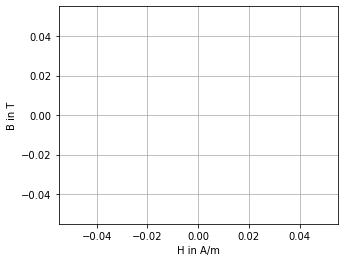

In [ ]:
# visuals setup
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=True,)
ax.grid()
ax.set_xlabel("H in A/m")
ax.set_ylabel("B in T")
lines = []
lines.append(ax.plot([], [], color="tab:blue", ls='-', alpha=0.5)[0])

time_template = 'observation = %d: loss = %.7f'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

In [ ]:
print("start animation")
def animate(epoch):
    row = material_df.iloc[epoch, :]
    for i, line in enumerate(lines):
        line.set_data(row.loc[[f"H_t_{t}" for t in range(1024)]].to_numpy(),
                      row.loc[[f"B_t_{t}" for t in range(1024)]].to_numpy())

    time_text.set_text(time_template % (epoch, 0))
    return time_text, *lines

ani = animation.FuncAnimation(fig, animate, frames=range(len(material_df)), interval=100, blit=True)
plt.show()


start animation


In [ ]:
ani.save("test.mp4") 

KeyboardInterrupt: 

## Visualize B-H-Curves

In [3]:
ds = pd.read_pickle(PROC_SOURCE / "ten_materials.pkl.gz")
b, h = ds.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), ds.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()

In [3]:
square_sine_template = np.repeat(np.array([1, -1]), 512)
sawtooth_template = np.hstack([np.linspace(-1, 1, 800), np.zeros(224)])
sine_template = np.sin(np.arange(1024)*2*np.pi/1024)
neg_cos_template = -np.cos(np.arange(1024)*2*np.pi/1024)

templates = np.column_stack([square_sine_template, sawtooth_template, sine_template, neg_cos_template]).T

<Figure size 1200x800 with 0 Axes>

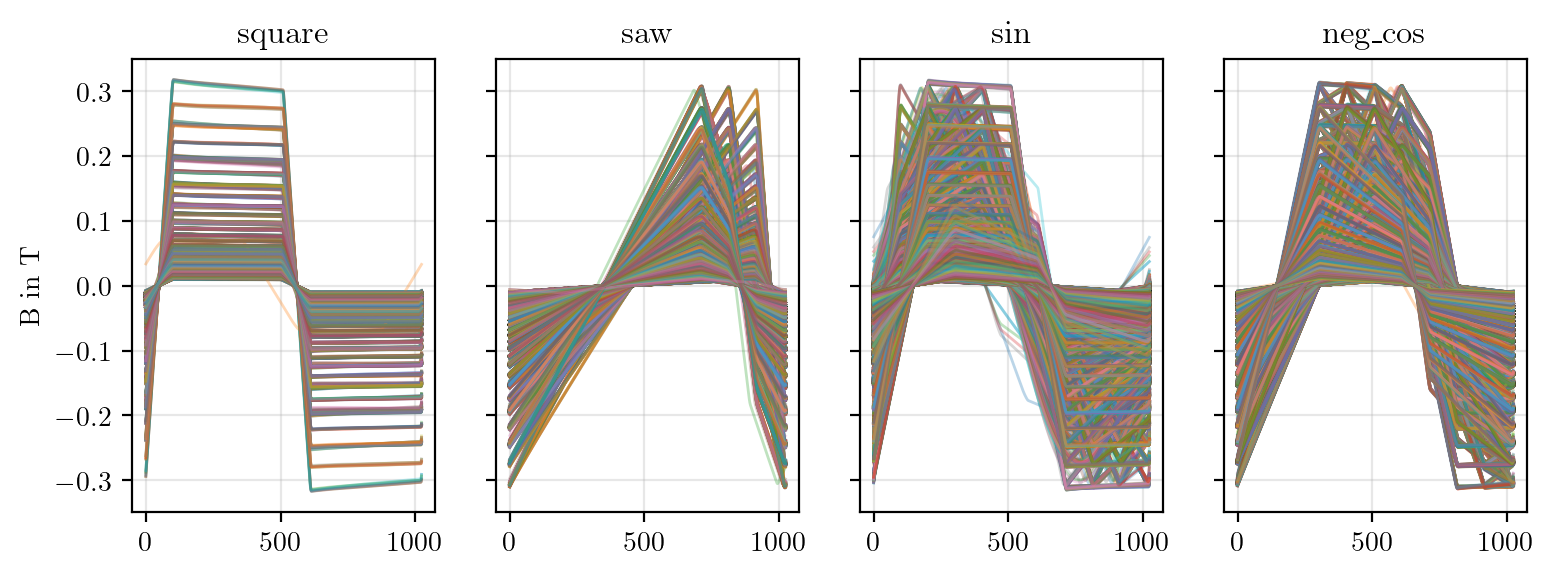

In [4]:
plt.figure(dpi=200)
t = np.arange(1024)
template_lbls = ["square", "saw", "sin", 'neg_cos']
cls_estimate = []
for bb, hh in zip(b, h):
    #plt.plot(hh, bb, alpha=0.5)
    cls_estimate.append(np.argmin(np.mean(np.abs(bb.reshape(1, -1) - templates*bb.max())[:, 100:900], axis=1), axis=0))
    #plt.plot(t, bb)
fig, axes = plt.subplots(1, len(template_lbls), dpi=200, figsize=(9, 3), sharex=True, sharey=True)

for i, cls in enumerate(cls_estimate):
    axes[cls].plot(b[i], alpha=0.3, lw=1.0)

axes[0].set_ylabel("B in T")
for i, lbl in enumerate(template_lbls):
    axes[i].set_title(lbl)

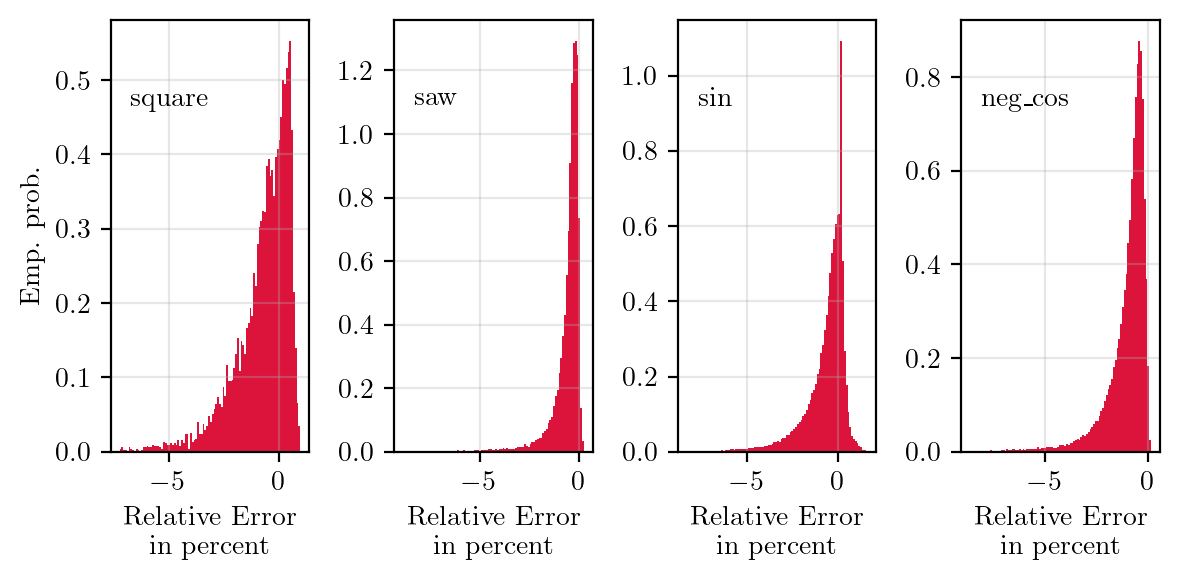

In [5]:
fig, axes = plt.subplots(1, len(template_lbls), sharex=False, sharey=False, dpi=200, figsize=(6, 3))
#plt.figure(dpi=200)
ds["waveform"] = cls_estimate
ds["computed_bh_area"] = get_bh_integral(ds)
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("waveform")):    
    calc_error = ( mat_df.computed_bh_area - mat_df.ploss) / mat_df.ploss
    ax.hist(calc_error*100 , color='crimson', bins=100, density=True)
    ax.text(0.1, 0.8, s=template_lbls[mat_lbl], transform=ax.transAxes )
    if ax == axes[0]:
        ax.set_ylabel("Emp. prob.")
    ax.set_xlabel("Relative Error\nin percent")
fig.tight_layout()

Text(0, 0.5, 'Rel. Error in percent')

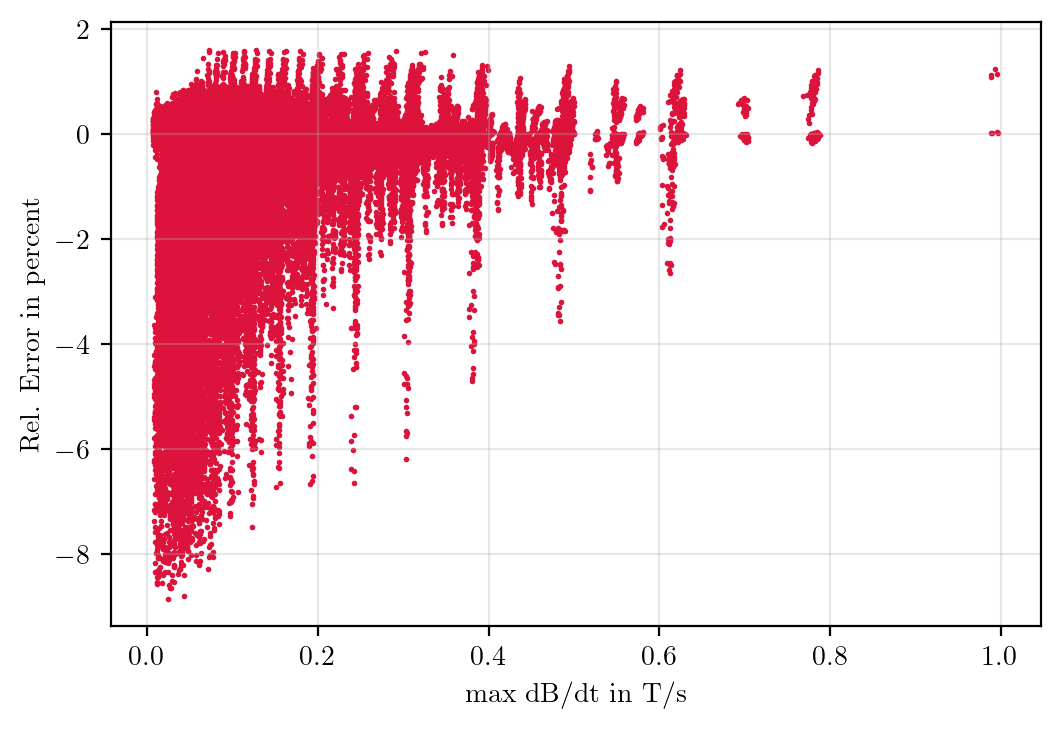

In [10]:
#ds["waveform"] = cls_estimate
ds["computed_bh_area"] = get_bh_integral(ds)
ds["max_dBdt"] = np.abs(b[:, 1:] - b[:, :-1]).max(axis=1)*ds.freq/1024
ds["ploss_rel_error"] = ( ds.computed_bh_area - ds.ploss) / ds.ploss

plt.figure(dpi=200)
plt.scatter(ds.max_dBdt, ds.ploss_rel_error*100, s=1.0, color='crimson')
plt.xlabel("max dB/dt in T/s")
plt.ylabel("Rel. Error in percent")

Text(0, 0.5, 'Rel. Error in percent')

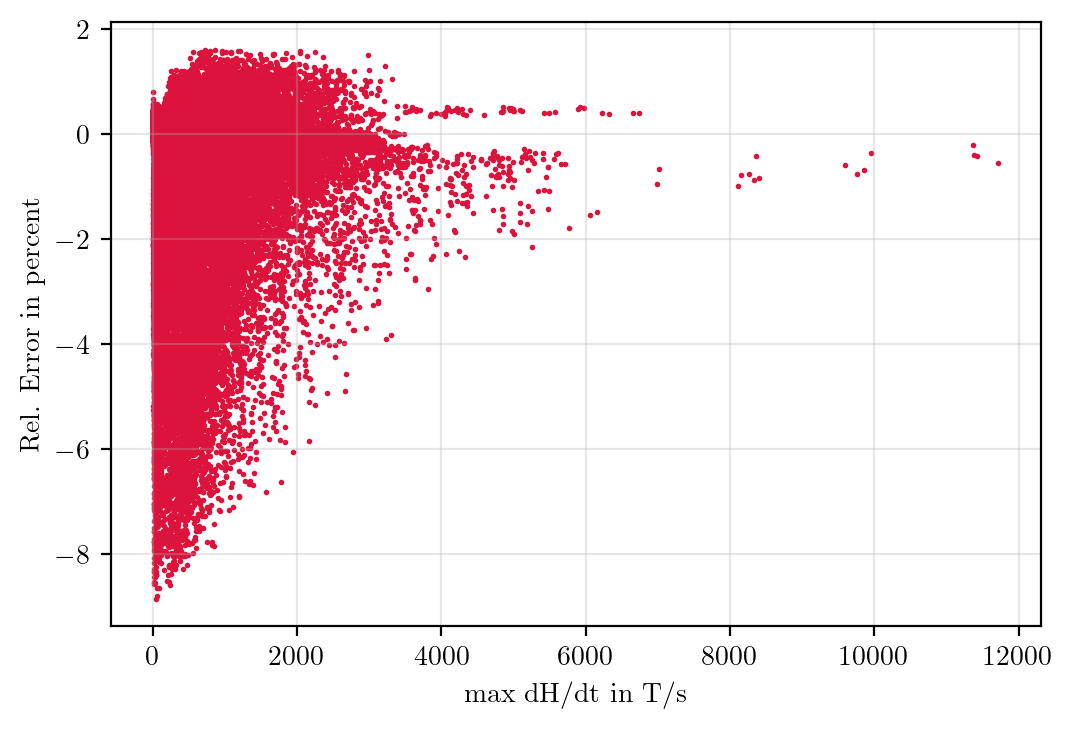

In [11]:
plt.figure(dpi=200)
plt.scatter(np.abs(h[:, 1:] - h[:, :-1]).max(axis=1)*ds.freq/1024, ds.ploss_rel_error*100, s=1.0, color='crimson')
plt.xlabel("max dH/dt in T/s")
plt.ylabel("Rel. Error in percent")

## Visualize Relative Error Ploss vs. Integral B-H

In [42]:
material_df = pd.read_pickle(PROC_SOURCE / 'ten_materials.pkl.gz')
material_df

,ploss,H_t_0,H_t_1,H_t_2,H_t_3,H_t_4,H_t_5,H_t_6,H_t_7,H_t_8,...,B_t_1017,B_t_1018,B_t_1019,B_t_1020,B_t_1021,B_t_1022,B_t_1023,temp,freq,material
0,3427.045851,0.172711,0.222592,0.258779,0.295567,0.361601,0.417298,0.473350,0.538819,0.552730,...,-0.003271,-0.003077,-0.002884,-0.002691,-0.002498,-0.002304,-0.002110,25,50020.0,77
1,6772.981613,1.207306,1.303059,1.364762,1.380317,1.476680,1.529389,1.572948,1.652259,1.676116,...,-0.001187,-0.000936,-0.000685,-0.000434,-0.000183,0.000068,0.000318,25,50020.0,77
2,12379.944813,1.733584,1.769329,1.880979,1.945082,2.000092,2.113439,2.184118,2.250676,2.295036,...,-0.001695,-0.001379,-0.001064,-0.000747,-0.000431,-0.000115,0.000202,25,50020.0,77
3,21492.763095,1.811638,1.893005,1.992778,2.017534,2.138280,2.185156,2.306230,2.320959,2.448897,...,-0.005028,-0.004637,-0.004245,-0.003852,-0.003459,-0.003066,-0.002674,25,50020.0,77
4,38218.806637,3.335907,3.397103,3.514572,3.573229,3.675034,3.736175,3.789300,3.947331,4.034298,...,-0.002556,-0.002051,-0.001546,-0.001042,-0.000538,-0.000033,0.000472,25,50020.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186742,130192.516389,3.393094,3.251408,3.078409,2.806555,2.476043,2.137501,1.837408,1.601283,1.447446,...,-0.020696,-0.020375,-0.020004,-0.019597,-0.019168,-0.018727,-0.018279,90,446420.0,3C94
186743,163806.431215,3.908963,3.742632,3.554716,3.258822,2.895474,2.518033,2.176047,1.899513,1.711416,...,-0.023162,-0.022819,-0.022419,-0.021975,-0.021503,-0.021013,-0.020514,90,446420.0,3C94
186744,206905.659713,4.340581,4.111461,3.834259,3.484286,3.098843,2.718887,2.377187,2.103369,1.931090,...,-0.025758,-0.025350,-0.024883,-0.024374,-0.023838,-0.023285,-0.022724,90,446410.0,3C94
186745,257313.520605,5.024791,4.708762,4.417428,4.060779,3.655791,3.230357,2.812500,2.441350,2.166872,...,-0.028979,-0.028551,-0.028052,-0.027499,-0.026908,-0.026295,-0.025668,90,446420.0,3C94


In [43]:
material_df.describe()

,ploss,H_t_0,H_t_1,H_t_2,H_t_3,H_t_4,H_t_5,H_t_6,H_t_7,H_t_8,...,B_t_1016,B_t_1017,B_t_1018,B_t_1019,B_t_1020,B_t_1021,B_t_1022,B_t_1023,temp,freq
count,1.867470e+05,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,...,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000,186747.000000
mean,2.574325e+05,-11.241866,-11.528974,-11.617410,-11.650237,-11.648748,-11.615384,-11.555865,-11.474415,-11.381877,...,-0.072788,-0.072803,-0.072781,-0.072707,-0.072561,-0.072321,-0.071966,-0.071500,58.694999,202431.555955
std,4.718214e+05,17.524913,17.454650,17.323020,17.170577,17.010870,16.843064,16.675081,16.518800,16.373292,...,0.064113,0.064227,0.064317,0.064371,0.064371,0.064296,0.064130,0.063872,24.096100,123495.971868
min,4.061182e+02,-357.400129,-350.613146,-342.869834,-336.012304,-331.105336,-325.898580,-320.592986,-316.310825,-311.308694,...,-0.310685,-0.310675,-0.310669,-0.310923,-0.311599,-0.312051,-0.311836,-0.311160,25.000000,49950.000000
25%,1.495398e+04,-14.822778,-15.195895,-15.358741,-15.423325,-15.442949,-15.422561,-15.361503,-15.265875,-15.161271,...,-0.097845,-0.097843,-0.097835,-0.097850,-0.097884,-0.097810,-0.097597,-0.097254,25.000000,99930.000000
50%,6.765390e+04,-6.108853,-6.395069,-6.521916,-6.612130,-6.654651,-6.693802,-6.699252,-6.679805,-6.657875,...,-0.049676,-0.049553,-0.049485,-0.049427,-0.049389,-0.049338,-0.049223,-0.049015,50.000000,158750.000000
75%,2.818233e+05,-1.891853,-2.115050,-2.185614,-2.243419,-2.303266,-2.352333,-2.369996,-2.371091,-2.356135,...,-0.024421,-0.024420,-0.024412,-0.024394,-0.024349,-0.024276,-0.024174,-0.024033,70.000000,282490.000000
max,6.793920e+06,42.554403,41.747739,41.982623,42.214147,42.454025,42.706146,42.953095,43.175451,43.382141,...,0.069261,0.070020,0.070778,0.071535,0.072294,0.073059,0.073836,0.074634,90.000000,794340.000000


In [27]:

material_df["computed_bh_area"] = get_bh_integral(material_df)
material_df.loc[:, ['ploss', 'computed_bh_area']]

NameError: name 'material_df' is not defined

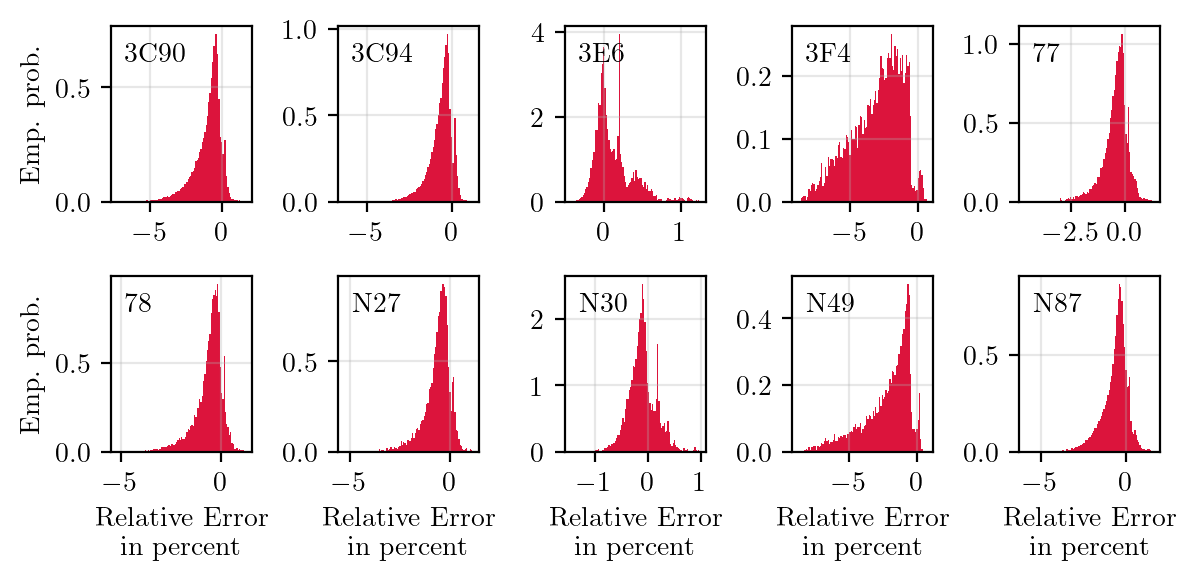

In [90]:
fig, axes = plt.subplots(2, 5, sharex=False, sharey=False, dpi=200, figsize=(6, 3))
#plt.figure(dpi=200)

for ax, (mat_lbl, mat_df) in zip(axes.flatten(), material_df.groupby("material")):    
    calc_error = ( mat_df.computed_bh_area - mat_df.ploss) / mat_df.ploss
    ax.hist(calc_error*100 , color='crimson', bins=100, density=True)
    ax.text(0.1, 0.8, s=mat_lbl, transform=ax.transAxes )
    if ax in axes[:, 0]:
        ax.set_ylabel("Emp. prob.")
    if ax in axes[1, :]:
        ax.set_xlabel("Relative Error\nin percent")
fig.tight_layout()

Text(0, 0.5, 'Relative error in percent')

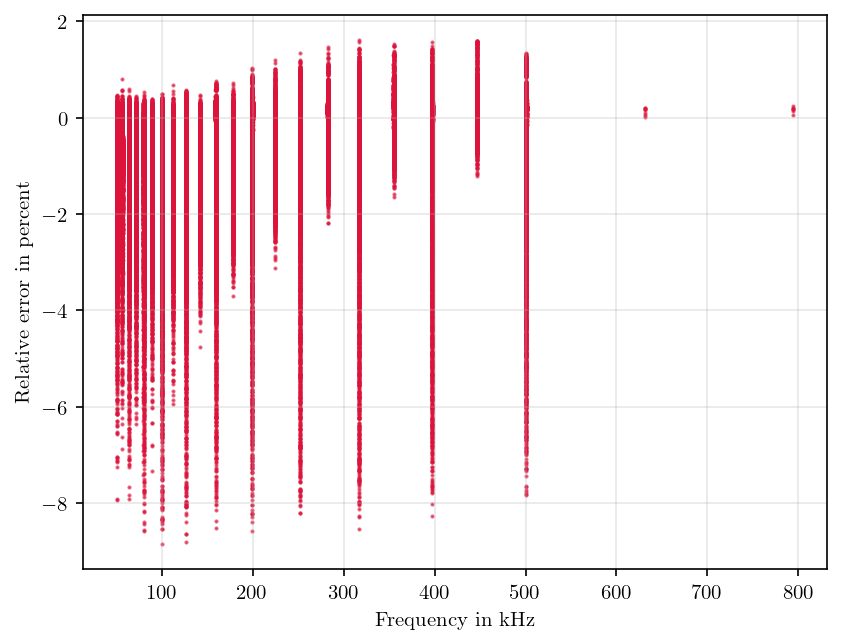

In [94]:
plt.figure(dpi=150)
plt.scatter(material_df.freq*1e-3, ( material_df.computed_bh_area - material_df.ploss) / material_df.ploss*100, color='crimson', s=1, alpha=0.6)
plt.xlabel("Frequency in kHz")
plt.ylabel("Relative error in percent")

Text(0, 0.5, 'Error in W/m³')

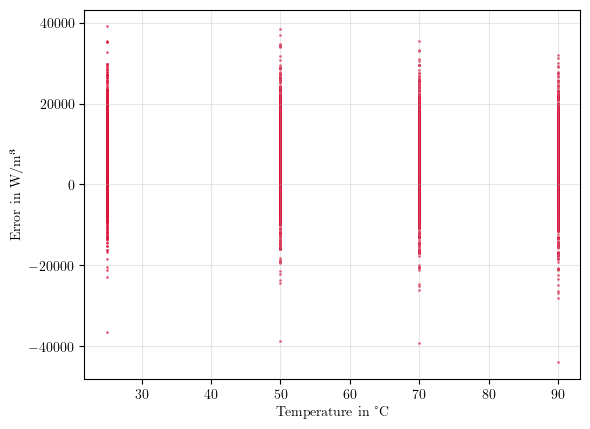

In [93]:
plt.figure(dpi=100)
plt.scatter(material_df.temp, material_df.ploss - material_df.computed_bh_area, color='crimson', s=1, alpha=0.6)
plt.xlabel("Temperature in °C")
plt.ylabel("Error in W/m³")